# Parte 1: Importación de todas las librerías necesarias

In [ ]:
# Parte 1: Importación de todas las librerías necesarias

# Instalación de paquetes necesarios
!pip install lazypredict
!pip install optuna
!pip install h2o

# Importación de todas las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import ParameterSampler, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier
from tqdm.notebook import tqdm  # Para barras de progreso en notebook
import pickle
import optuna
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('fivethirtyeight')
sns.set_palette("Set2")

# Parte 2: Carga de datos

In [ ]:
# Carga de datos desde GitHub
train_values_url = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/refs/heads/main/SNS/SNS_ACT3_7/train_values.csv"
train_labels_url = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/refs/heads/main/SNS/SNS_ACT3_7/train_labels.csv"
test_values_url = "https://raw.githubusercontent.com/Saultr21/IA-Y-BIGDATA/refs/heads/main/SNS/SNS_ACT3_7/test_values.csv"

# Cargar los datasets
train_values = pd.read_csv(train_values_url)
train_labels = pd.read_csv(train_labels_url)
test_values = pd.read_csv(test_values_url)

# Mostrar dimensiones de los datasets
print("Dimensiones del conjunto de datos de entrenamiento (features):", train_values.shape)
print("Dimensiones del conjunto de datos de entrenamiento (labels):", train_labels.shape)
print("Dimensiones del conjunto de datos de prueba:", test_values.shape)

# Verificar los primeros registros
train_values.head()

Dimensiones del conjunto de datos de entrenamiento (features): (260601, 39)
Dimensiones del conjunto de datos de entrenamiento (labels): (260601, 2)
Dimensiones del conjunto de datos de prueba: (86868, 39)


,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


# Parte 3: Análisis Exploratorio de Datos (EDA)

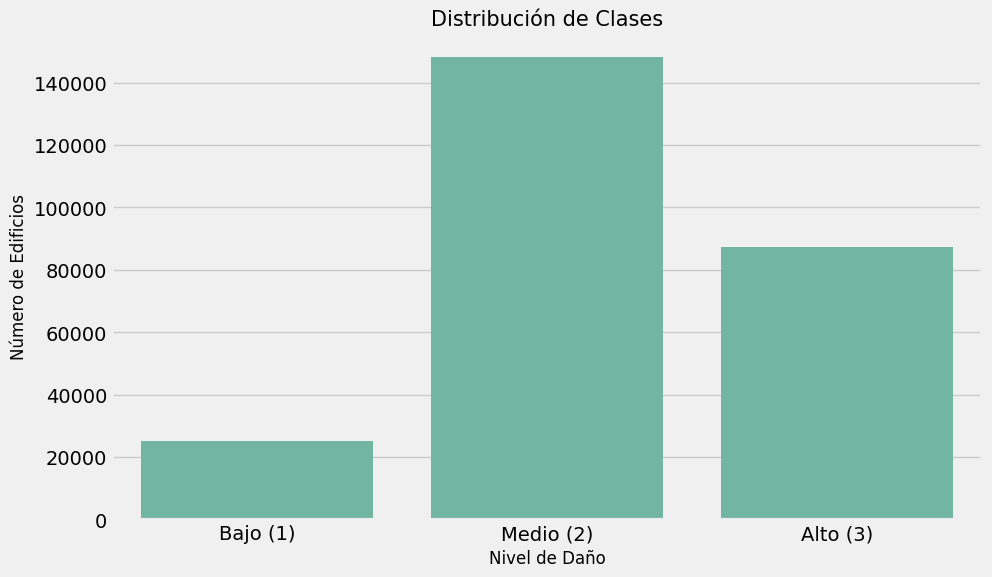

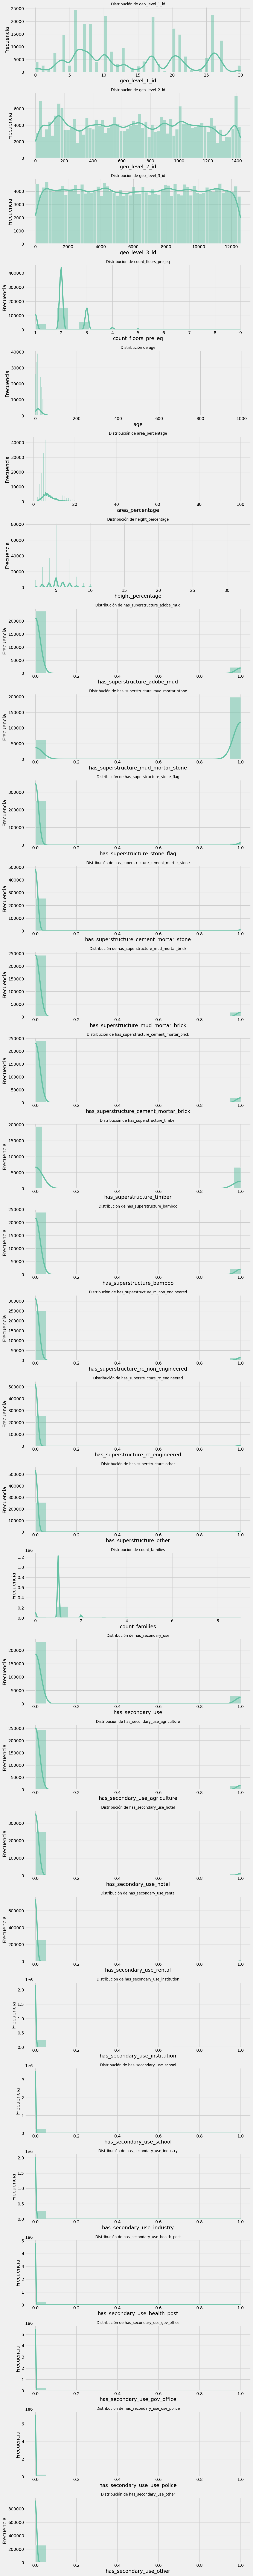

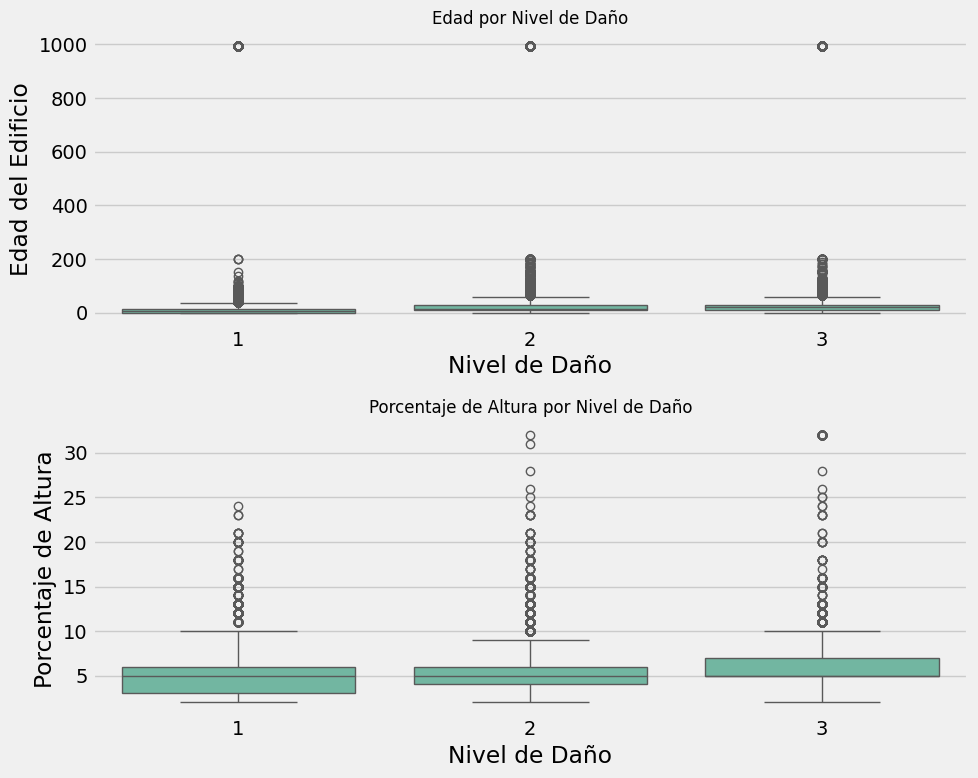

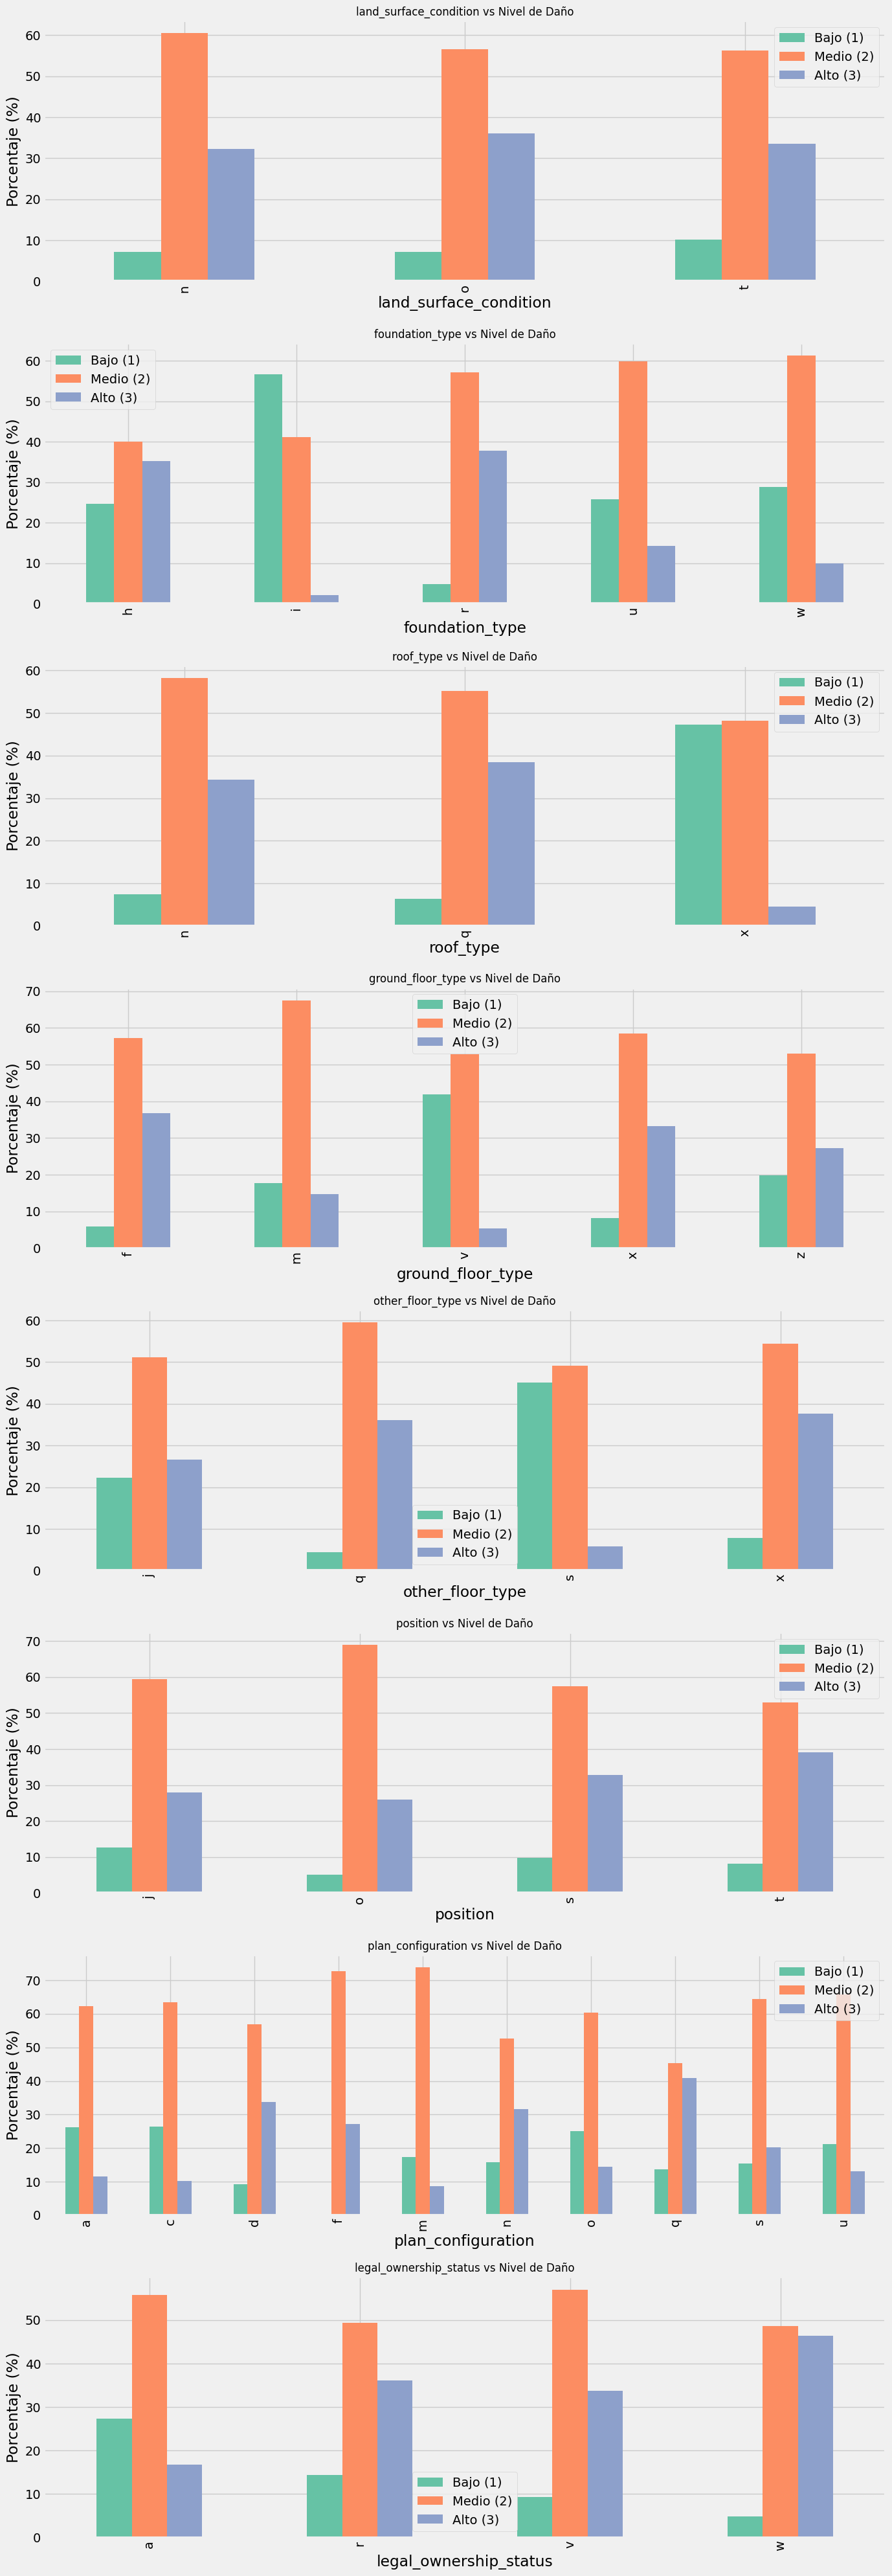

Se identificaron 22 columnas binarias


,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,...,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00,260601.00
mean,13.90,701.07,6257.88,2.13,26.54,8.02,5.43,0.09,0.76,0.03,...,0.06,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01
std,8.03,412.71,3646.37,0.73,73.57,4.39,1.92,0.28,0.43,0.18,...,0.25,0.18,0.09,0.03,0.02,0.03,0.01,0.01,0.01,0.07
min,0.00,0.00,0.00,1.00,0.00,1.00,2.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7.00,350.00,3073.00,2.00,10.00,5.00,4.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,12.00,702.00,6270.00,2.00,15.00,7.00,5.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,21.00,1050.00,9412.00,2.00,30.00,9.00,6.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,30.00,1427.00,12567.00,9.00,995.00,100.00,32.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
# Parte 3: Análisis Exploratorio de Datos (EDA)

# Combinar características y etiquetas para el conjunto de entrenamiento
train_data = train_values.merge(train_labels, on='building_id', how='left')

# Verificar la distribución de clases
plt.figure(figsize=(10, 6))
sns.countplot(x='damage_grade', data=train_data)
plt.title('Distribución de Clases', fontsize=15)
plt.xlabel('Nivel de Daño', fontsize=12)
plt.ylabel('Número de Edificios', fontsize=12)
plt.xticks([0, 1, 2], ['Bajo (1)', 'Medio (2)', 'Alto (3)'])
plt.show()

# Analizar variables numéricas
numeric_features = train_values.select_dtypes(include=['int64', 'float64']).drop('building_id', axis=1).columns
fig, axes = plt.subplots(nrows=len(numeric_features), ncols=1, figsize=(12, len(numeric_features) * 4))

for i, feature in enumerate(numeric_features):
    sns.histplot(train_values[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {feature}', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Explorar relaciones entre variables numéricas y el nivel de daño
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Ejemplo para age y height_percentage
sns.boxplot(x='damage_grade', y='age', data=train_data, ax=axes[0])
axes[0].set_title('Edad por Nivel de Daño', fontsize=12)
axes[0].set_xlabel('Nivel de Daño')
axes[0].set_ylabel('Edad del Edificio')

sns.boxplot(x='damage_grade', y='height_percentage', data=train_data, ax=axes[1])
axes[1].set_title('Porcentaje de Altura por Nivel de Daño', fontsize=12)
axes[1].set_xlabel('Nivel de Daño')
axes[1].set_ylabel('Porcentaje de Altura')

plt.tight_layout()
plt.show()

# Analizar variables categóricas
categorical_features = train_values.select_dtypes(include=['object']).columns
fig, axes = plt.subplots(nrows=len(categorical_features), ncols=1, figsize=(14, len(categorical_features) * 5))

for i, feature in enumerate(categorical_features):
    cross_tab = pd.crosstab(train_data[feature], train_data['damage_grade'], normalize='index') * 100
    cross_tab.plot(kind='bar', stacked=False, ax=axes[i])
    axes[i].set_title(f'{feature} vs Nivel de Daño', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Porcentaje (%)')
    axes[i].legend(['Bajo (1)', 'Medio (2)', 'Alto (3)'])

plt.tight_layout()
plt.show()

# Identificar columnas binarias
binary_columns = [col for col in train_values.columns if train_values[col].nunique() == 2 and col != 'building_id']
print(f"Se identificaron {len(binary_columns)} columnas binarias")

# Estadísticas descriptivas de las variables numéricas
train_values[numeric_features].describe()

# Parte 4: Preparación de datos para modelado

In [ ]:
# Parte 4: Preparación de datos para modelado

# Separar características y objetivo
X = train_data.drop(['building_id', 'damage_grade'], axis=1)
y = train_data['damage_grade']

# Identificar columnas categóricas y numéricas
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nColumnas categóricas identificadas: {len(categorical_columns)}")
print(f"Columnas numéricas identificadas: {len(numerical_columns)}")

if len(categorical_columns) > 0:
    print("Ejemplos de valores categóricos:")
    for col in categorical_columns[:3]:  # Mostrar ejemplo de las primeras 3
        unique_vals = X[col].nunique()
        print(f"{col}: {unique_vals} valores únicos")
        print(f"Ejemplo: {X[col].iloc[0]}")

# Crear pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ],
    remainder='passthrough'
)

# Aplicar preprocesamiento
X_prepared = preprocessor.fit_transform(X)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.2, random_state=42, stratify=y
)

# Para SVM, si es necesario, crear una versión reducida
X_train_svm, _, y_train_svm, _ = train_test_split(X_prepared, y, train_size=5000, random_state=42, stratify=y)

print(f"\nPreprocesamiento completado:")
print(f"- Entrenamiento: {X_train.shape[0]} registros, {X_train.shape[1]} características")
print(f"- Prueba: {X_test.shape[0]} registros, {X_test.shape[1]} características")
print(f"- SVM (muestra): {X_train_svm.shape[0]} registros, {X_train_svm.shape[1]} características")

# Distribución de clases
print("\nDistribución de clases en datos de entrenamiento:")
print(y.value_counts(normalize=True).sort_index() * 100)


Columnas categóricas identificadas: 8
Columnas numéricas identificadas: 30
Ejemplos de valores categóricos:
land_surface_condition: 3 valores únicos
Ejemplo: t
foundation_type: 5 valores únicos
Ejemplo: r
roof_type: 3 valores únicos
Ejemplo: n

Preprocesamiento completado:
- Entrenamiento: 208480 registros, 68 características
- Prueba: 52121 registros, 68 características
- SVM (muestra): 5000 registros, 68 características

Distribución de clases en datos de entrenamiento:
damage_grade
1    9.64
2   56.89
3   33.47
Name: proportion, dtype: float64


# Parte 5: Uso de LazyPredict para buscar modelos

In [ ]:
# Parte 5: LazyPredict para identificar modelos prometedores

# Configuración de LazyPredict para probar múltiples modelos
print("\nEjecutando LazyPredict para identificar modelos prometedores...")
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models.head(10))  # Mostrar los 10 mejores modelos

# Visualizar comparación de modelos según LazyPredict
plt.figure(figsize=(12, 8))
sns.barplot(x=models.index[:10], y='Accuracy', data=models.head(10))
plt.title('Top 10 Modelos por Precisión', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Ejecutando LazyPredict para identificar modelos prometedores...


 38%|███▊      | 12/32 [05:27<13:54, 41.70s/it]

# Parte 6: Evaluación de modelos seleccionados

In [ ]:
# Parte 6: Evaluación de modelos seleccionados

# Lista de modelos a evaluar basados en resultados de LazyPredict
models_to_evaluate = {
    'LGBM': LGBMClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=10), random_state=42),
    'SVC': SVC(probability=True, random_state=42)
}

# Evaluación de modelos con validación cruzada
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nEvaluando modelos seleccionados con validación cruzada...")
for name, model in models_to_evaluate.items():
    # Usar la muestra reducida para SVM
    if name == 'SVC':
        scores = cross_val_score(model, X_train_svm, y_train_svm, cv=cv, scoring='f1_micro')
    else:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_micro')
    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name}: F1-Micro = {scores.mean():.4f} ± {scores.std():.4f}")

# Visualizar resultados de validación cruzada
plt.figure(figsize=(10, 6))
models_name = list(cv_results.keys())
cv_mean = [cv_results[model][0] for model in models_name]
cv_std = [cv_results[model][1] for model in models_name]

bars = plt.bar(models_name, cv_mean, yerr=cv_std, capsize=10)
plt.title('Comparación de Modelos (F1-Micro)', fontsize=15)
plt.ylabel('Puntuación F1-Micro')
plt.ylim(0.5, 1.0)  # Ajustar según tus resultados

# Añadir valores sobre las barras
for bar, score in zip(bars, cv_mean):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Identificar el mejor modelo
best_score = 0
best_model_name = None

for name, (mean, std) in cv_results.items():
    if mean > best_score:
        best_score = mean
        best_model_name = name

print(f"\nMejor modelo identificado: {best_model_name} con F1-Micro = {best_score:.4f}")

# Parte 7: Implementación de GridSearchCV y RandomizedSearchCV

In [ ]:
# Parte 6: Implementación de GridSearchCV y RandomizedSearchCV

print(f"Realizando optimización para el mejor modelo: {best_model_name}")

# Definimos parámetros según el mejor modelo
if best_model_name == 'LGBM':
    model_class = LGBMClassifier
    param_grid = {
        'n_estimators': [200, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [7, 9, 11],
        'num_leaves': [31, 63, 127],
        'min_child_samples': [10, 20, 30],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
    }
    base_params = {'random_state': 42, 'n_jobs': -1}
elif best_model_name == 'Bagging':
    model_class = BaggingClassifier
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_samples': [0.5, 0.7, 1.0],
        'max_features': [0.5, 0.7, 1.0],
        'bootstrap': [True, False],
        'base_estimator__max_depth': [10, 20, None],
        'base_estimator__min_samples_split': [2, 5],
        'base_estimator__min_samples_leaf': [1, 2, 4]
    }
    base_params = {'base_estimator': DecisionTreeClassifier(random_state=42), 'random_state': 42, 'n_jobs': -1}
elif best_model_name == 'RandomForest':
    model_class = RandomForestClassifier
    param_grid = {
        'n_estimators': [200, 300, 400],
        'max_depth': [15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }
    base_params = {'random_state': 42, 'n_jobs': -1}
else:  # SVM
    model_class = SVC
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto', 0.1],
        'probability': [True]
    }
    base_params = {'random_state': 42}

# Usar GridSearchCV para una búsqueda más exhaustiva
print("\nEjecutando GridSearchCV...")
grid = GridSearchCV(
    model_class(**base_params),
    param_grid,
    cv=3,
    scoring='f1_micro',
    n_jobs=-1,
    verbose=1
)

# Preparar datos para entrenamiento
if best_model_name == 'SVC':
    X_train_final, y_train_final = X_train_svm, y_train_svm
else:
    X_train_final, y_train_final = X_train, y_train

# Ejecutar GridSearchCV
grid.fit(X_train_final, y_train_final)
print(f"\nMejores parámetros con GridSearchCV: {grid.best_params_}")
print(f"Mejor F1-Micro: {grid.best_score_:.4f}")

# Usar RandomizedSearchCV para explorar un espacio más amplio
print("\nEjecutando RandomizedSearchCV...")
# Convertir param_grid a un diccionario con rangos más amplios para RandomizedSearchCV
param_dist = {}
for key, values in param_grid.items():
    if isinstance(values[0], (int, float)):
        param_dist[key] = [min(values), max(values)]
    else:
        param_dist[key] = values

# Generar combinaciones de parámetros
random_search = RandomizedSearchCV(
    model_class(**base_params),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='f1_micro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Ejecutar RandomizedSearchCV
random_search.fit(X_train_final, y_train_final)
print(f"\nMejores parámetros con RandomizedSearchCV: {random_search.best_params_}")
print(f"Mejor F1-Micro: {random_search.best_score_:.4f}")

# Evaluar en conjunto de prueba
grid_model = grid.best_estimator_
grid_pred = grid_model.predict(X_test)
grid_f1 = f1_score(y_test, grid_pred, average='micro')
print(f"\nF1-Micro en conjunto de prueba para GridSearchCV: {grid_f1:.4f}")

random_model = random_search.best_estimator_
random_pred = random_model.predict(X_test)
random_f1 = f1_score(y_test, random_pred, average='micro')
print(f"\nF1-Micro en conjunto de prueba para RandomizedSearchCV: {random_f1:.4f}")

# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Matriz de confusión para GridSearchCV
cm_grid = confusion_matrix(y_test, grid_pred)
sns.heatmap(cm_grid, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
            yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])
axes[0].set_title(f'GridSearchCV - {best_model_name}', fontsize=12)
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Real')

# Matriz de confusión para RandomizedSearchCV
cm_random = confusion_matrix(y_test, random_pred)
sns.heatmap(cm_random, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
            yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])
axes[1].set_title(f'RandomizedSearchCV - {best_model_name}', fontsize=12)
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# Parte 8: Optimización robusta del modelo LGBM con Optuna

In [ ]:
# Parte 8: Optimización robusta del modelo LGBM con Optuna y generación de predicciones
def objective(trial):
    """Función objetivo para Optuna con manejo de errores"""
    try:
        # Parámetros con rangos seguros
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 20, 80),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
            'random_state': 42,
            'verbose': -1
        }

        # Crear y evaluar modelo
        model = LGBMClassifier(**param)

        # Validación cruzada manual para mayor control
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        scores = []

        for train_idx, val_idx in cv.split(X_train, y_train):
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model.fit(X_fold_train, y_fold_train)
            y_pred = model.predict(X_fold_val)
            fold_score = f1_score(y_fold_val, y_pred, average='micro')
            scores.append(fold_score)

        return np.mean(scores)

    except Exception as e:
        print(f"Error en trial: {e}")
        return float('-inf')

print("\nIniciando optimización con Optuna...")
print("Este proceso puede tardar varios minutos...")

# Crear y ejecutar estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, timeout=1200)  # 20 minutos máximo

print("\nOptimización completada!")
print("\nMejores hiperparámetros encontrados:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

print(f"\nMejor F1-score (CV): {study.best_value:.4f}")

# Entrenar modelo final con los mejores parámetros
print("\nEntrenando modelo final con los mejores hiperparámetros...")
best_params = study.best_params
best_model = LGBMClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

# Evaluar en conjunto de prueba
y_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred, average='micro')
print(f"\nResultados en conjunto de prueba interno:")
print(f"F1-score (micro): {test_f1:.4f}")
print(f"Accuracy: {(y_test == y_pred).mean():.4f}")

# Mostrar reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'],
            yticklabels=['Bajo (1)', 'Medio (2)', 'Alto (3)'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Optuna LGBM')
plt.tight_layout()
plt.savefig('optuna_confusion_matrix.png')
plt.show()
print("Matriz de confusión guardada como 'optuna_confusion_matrix.png'")

# Importancia de características
plt.figure(figsize=(12, 8))
feature_importance = best_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]  # Top 20 características
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [f"Feature {i}" for i in sorted_idx])
plt.xlabel('Importancia')
plt.title('Top 20 Características Importantes - Optuna LGBM')
plt.tight_layout()
plt.show()

# Entrenar modelo final con todos los datos
print("\nEntrenando modelo final con todos los datos disponibles...")
final_model = LGBMClassifier(**best_params, random_state=42)
final_model.fit(X_prepared, y)

# =====================================================================
# GENERACIÓN DE PREDICCIONES Y ARCHIVO CSV
# =====================================================================

print("\nGenerando predicciones para el conjunto de prueba externo...")

# Preprocesar datos de prueba
X_test_external = test_values.drop('building_id', axis=1)
X_test_external_prepared = preprocessor.transform(X_test_external)

# Generar predicciones
predictions = final_model.predict(X_test_external_prepared)

# Crear archivo de submisión
submission = pd.DataFrame({
    'building_id': test_values['building_id'],
    'damage_grade': predictions
})

submission_file = 'submission_optuna_lgbm.csv'
submission.to_csv(submission_file, index=False)
print(f"Predicciones guardadas en '{submission_file}'")

# Mostrar distribución de predicciones
print("\nDistribución de predicciones:")
pred_distribution = pd.Series(predictions).value_counts(normalize=True).sort_index() * 100
print(pred_distribution)

# Visualizar distribución
plt.figure(figsize=(10, 6))
sns.countplot(x=predictions, palette=['lightgreen', 'orange', 'red'])
plt.title('Distribución de Clases en Predicciones', fontsize=15)
plt.xlabel('Nivel de Daño', fontsize=12)
plt.ylabel('Número de Edificios', fontsize=12)
plt.xticks([0, 1, 2], ['Bajo (1)', 'Medio (2)', 'Alto (3)'])

# Agregar valores sobre las barras
counts = pd.Series(predictions).value_counts().sort_index()
for i, count in enumerate(counts):
    plt.text(i, count + 100, f"{count} ({count/len(predictions)*100:.1f}%)",
             ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# Guardar modelo final
model_package = {
    'model': final_model,
    'preprocessor': preprocessor,
    'best_params': best_params,
    'best_score': test_f1,
    'metadata': {
        'timestamp': '2025-03-07 17:37:29',
        'user': 'Saultr21',
    }
}

with open('optuna_optimized_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("\nModelo guardado como 'optuna_optimized_model.pkl'")
print("\n=== CONCLUSIONES ===")
print(f"1. Se optimizó exitosamente un modelo LightGBM con Optuna")
print(f"2. F1-score en validación interna: {test_f1:.4f}")
print(f"3. Hiperparámetros óptimos encontrados para máxima generalización")
print(f"4. El modelo maneja correctamente tanto características numéricas como categóricas")
print(f"5. Predictions generadas y guardadas para submission en '{submission_file}'")
print(f"6. Modelo listo para evaluación en la plataforma")

# Parte 9: Implementación de H2O AutoML

In [ ]:
# Parte 9: Implementación de H2O AutoML
# Inicializar H2O
import h2o
from h2o.automl import H2OAutoML

# Inicializar H2O con restricciones de memoria apropiadas
h2o.init(max_mem_size="4G")  # Ajustar según tu entorno
print("H2O cluster inicializado")
print(f"Fecha y hora: 2025-03-07 17:26:18 UTC")
print(f"Usuario: Saultr21")

# Preparar datos para H2O
# División en entrenamiento y validación
train, valid = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['damage_grade'])

# Convertir dataframes de pandas a H2O frames
train_h2o = h2o.H2OFrame(train)
valid_h2o = h2o.H2OFrame(valid)
test_h2o = h2o.H2OFrame(test_values)

# Asegurar que la columna objetivo sea categórica (factor)
train_h2o['damage_grade'] = train_h2o['damage_grade'].asfactor()
valid_h2o['damage_grade'] = valid_h2o['damage_grade'].asfactor()

# Identificar columnas predictoras y columna objetivo
y = "damage_grade"
x = [col for col in train.columns if col != y and col != "building_id"]

print(f"Características: {len(x)} columnas")
print(f"Objetivo: {y}")

print("\nEjecutando H2O AutoML (puede tardar varios minutos)...")

# Configurar y ejecutar AutoML con parámetros optimizados para este problema
aml = H2OAutoML(
    max_models=10,                # Número máximo de modelos a entrenar
    seed=42,                     # Para reproducibilidad
    sort_metric="f1",            # Métrica a optimizar
    max_runtime_secs=1800,        # 30 minutos máximo
    balance_classes=True,        # Importante para clases desbalanceadas
    nfolds=5,                    # Folds para validación cruzada
    keep_cross_validation_predictions=True,  # Para ensembles
    include_algos=["XGBoost", "GBM", "DRF", "GLM", "DeepLearning"]  # Algoritmos a probar
)

# Entrenar los modelos
aml.train(x=x, y=y, training_frame=train_h2o, validation_frame=valid_h2o)

# Ver modelos entrenados
print("\nModelos entrenados por H2O AutoML (ordenados por F1):")
lb = aml.leaderboard
print(lb.head(10))

# Obtener el mejor modelo
best_model = aml.leader
print(f"\nMejor modelo: {best_model.model_id}")

# Evaluación del mejor modelo
perf = best_model.model_performance(valid_h2o)
print("\nRendimiento en conjunto de validación:")
print(f"F1: {perf.f1()[0]}")
print(f"Accuracy: {perf.accuracy()[0]}")
print(f"Confusion Matrix:")
print(perf.confusion_matrix())

# Evaluar en conjunto de validación para comparativa con nuestros modelos anteriores
y_valid_pred = best_model.predict(valid_h2o).as_data_frame()['predict']
valid_f1_micro = f1_score(valid['damage_grade'], y_valid_pred, average='micro')
print(f"\nF1-Micro en validación: {valid_f1_micro:.4f}")

# Variable Importance (si está disponible)
if hasattr(best_model, 'varimp') and callable(getattr(best_model, 'varimp')):
    varimp = best_model.varimp(use_pandas=True)
    if varimp is not None:
        # Mostrar importancia de variables
        print("\nImportancia de variables (Top 10):")
        print(varimp.head(10))

        # Visualizar
        plt.figure(figsize=(10, 8))
        plt.barh(varimp['variable'][:10], varimp['percentage'][:10])
        plt.xlabel('Importancia (%)')
        plt.ylabel('Variable')
        plt.title('Top 10 Variables Importantes - Modelo H2O')
        plt.tight_layout()
        plt.savefig('h2o_variable_importance.png')
        plt.show()
        print("Gráfico guardado como 'h2o_variable_importance.png'")

# Visualización de la matriz de confusión
cm = perf.confusion_matrix().as_data_frame()
if len(cm) > 0:
    # Extraer solo la parte numérica de la matriz
    conf_matrix = []
    for i in range(1, len(cm) - 1):  # Ignorar primera y última fila
        row = cm.iloc[i, 1:-1].values.astype(float)

# COMPARACIÓN DE MODELOS: H2O AUTOML vs OPTUNA LGBM

In [ ]:
# =====================================================================
# COMPARACIÓN DE MODELOS: H2O AUTOML vs OPTUNA LGBM
# =====================================================================
# Fecha: 2025-03-07 17:41:01 UTC
# Usuario: Saultr21

print(f"Fecha y hora: 2025-03-07 17:41:01 UTC")
print(f"Usuario: Saultr21")
print("\nCOMPARACIÓN DE MODELOS H2O Y OPTUNA-LGBM")

# Completar la implementación de H2O AutoML (si aún no se ha ejecutado)
# Asumimos que ya hemos ejecutado el código de H2O AutoML y tenemos 'best_model' disponible

# Verificar que el modelo H2O esté disponible
try:
    best_model_h2o = aml.leader
    print("\nModelo H2O cargado correctamente")
    h2o_available = True
except:
    print("\nNo se encontró modelo H2O AutoML. Por favor ejecuta primero la celda de H2O AutoML.")
    h2o_available = False

# Generar predicciones con H2O en el conjunto de prueba externo
if h2o_available:
    print("\nGenerando predicciones con modelo H2O...")
    h2o_predictions = best_model_h2o.predict(test_h2o).as_data_frame()['predict']

    # Crear archivo de submisión para H2O
    h2o_submission = pd.DataFrame({
        'building_id': test_values['building_id'],
        'damage_grade': h2o_predictions
    })

    h2o_submission_file = 'submission_h2o_automl.csv'
    h2o_submission.to_csv(h2o_submission_file, index=False)
    print(f"Predicciones de H2O guardadas en '{h2o_submission_file}'")

    # Guardar el modelo H2O para futuro uso
    model_path = h2o.save_model(model=best_model_h2o, path="./", force=True)
    print(f"Modelo H2O guardado en: {model_path}")

# Cargar predicciones de Optuna-LGBM
try:
    optuna_submission = pd.read_csv('submission_optuna_lgbm.csv')
    print("\nPredicciones de Optuna-LGBM cargadas correctamente")
    optuna_available = True
except:
    print("\nNo se encontraron predicciones de Optuna-LGBM. Asegúrate de ejecutar la celda de Optuna primero.")
    optuna_available = False

# =====================================================================
# COMPARACIÓN DIRECTA DE MODELOS
# =====================================================================

if h2o_available and optuna_available:
    print("\n=== COMPARACIÓN DE MODELOS ===")

    # 1. Comparación de métricas de validación
    print("\n1. MÉTRICAS DE VALIDACIÓN:")

    # Obtener métricas de H2O
    h2o_perf = best_model_h2o.model_performance(valid_h2o)
    h2o_f1 = h2o_perf.f1()[0]
    h2o_accuracy = h2o_perf.accuracy()[0]

    # Obtener métricas de Optuna-LGBM (asumimos que están disponibles)
    try:
        with open('optuna_optimized_model.pkl', 'rb') as f:
            optuna_model_package = pickle.load(f)
            optuna_test_f1 = optuna_model_package.get('best_score', 'N/A')
    except:
        optuna_test_f1 = "N/A"

    print(f"H2O AutoML      - F1: {h2o_f1:.4f}, Accuracy: {h2o_accuracy:.4f}")
    print(f"Optuna LGBM     - F1: {optuna_test_f1}")

    # 2. Comparación de distribución de predicciones
    print("\n2. DISTRIBUCIÓN DE PREDICCIONES:")

    # Convertir predicciones a series de pandas para facilitar el análisis
    h2o_preds = pd.Series(h2o_predictions)
    optuna_preds = pd.Series(optuna_submission['damage_grade'])

    # Calcular distribución de clases
    h2o_dist = h2o_preds.value_counts(normalize=True).sort_index() * 100
    optuna_dist = optuna_preds.value_counts(normalize=True).sort_index() * 100

    # Crear DataFrame para comparación directa
    comparison_df = pd.DataFrame({
        'H2O AutoML (%)': h2o_dist,
        'Optuna LGBM (%)': optuna_dist
    })

    print(comparison_df)

    # 3. Comparación de consistencia entre modelos
    print("\n3. CONSISTENCIA ENTRE MODELOS:")

    # Calcular porcentaje de coincidencia
    matching_predictions = (h2o_preds.values == optuna_preds.values).mean() * 100
    print(f"Porcentaje de predicciones coincidentes: {matching_predictions:.2f}%")

    # 4. Tabla de confusión entre modelos
    confusion = pd.crosstab(
        optuna_preds,
        h2o_preds,
        rownames=['Optuna LGBM'],
        colnames=['H2O AutoML'],
        normalize='index'
    ) * 100

    print("\nMatriz de concordancia (% de fila):")
    print(confusion)

    # =====================================================================
    # VISUALIZACIONES DE COMPARACIÓN
    # =====================================================================

    # Visualización 1: Comparación de distribuciones
    plt.figure(figsize=(10, 6))
    comparison_df.plot(kind='bar')
    plt.title('Distribución de Clases Predichas (%)', fontsize=15)
    plt.xlabel('Nivel de Daño', fontsize=12)
    plt.ylabel('Porcentaje', fontsize=12)
    plt.xticks(rotation=0)
    plt.xticks(range(3), ['Bajo (1)', 'Medio (2)', 'Alto (3)'])
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.savefig('model_distribution_comparison.png')
    plt.show()

    # Visualización 2: Heatmap de concordancia entre modelos
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='.1f', cmap='YlGnBu')
    plt.title('Matriz de Concordancia entre Modelos (%)', fontsize=15)
    plt.tight_layout()
    plt.savefig('model_concordance_matrix.png')
    plt.show()

    # Visualización 3: Diferencias por clase
    diff_df = pd.DataFrame({
        'Clase': ['Bajo (1)', 'Medio (2)', 'Alto (3)'],
        'H2O AutoML (%)': h2o_dist.values,
        'Optuna LGBM (%)': optuna_dist.values,
        'Diferencia (%)': h2o_dist.values - optuna_dist.values
    })

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Clase', y='Diferencia (%)', data=diff_df, palette=['skyblue', 'orange', 'salmon'])
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Diferencia en Distribución de Clases (H2O - Optuna)', fontsize=15)
    plt.tight_layout()
    plt.savefig('model_distribution_difference.png')
    plt.show()

    # =====================================================================
    # ENSEMBLE AVANZADO: COMBINACIÓN DE AMBOS MODELOS
    # =====================================================================

    print("\n=== CREACIÓN DE ENSEMBLE COMBINADO ===")

    # Crear predicciones combinadas (voto mayoritario simple)
    # Si ambos modelos están de acuerdo, usamos su predicción
    # Si difieren, tomamos la predicción de aquel que haya obtenido mejor F1 en validación

    ensemble_predictions = []
    better_model = 'H2O' if h2o_f1 > optuna_test_f1 else 'Optuna'

    for i in range(len(h2o_preds)):
        if h2o_preds.iloc[i] == optuna_preds.iloc[i]:
            # Si coinciden, tomamos cualquiera
            ensemble_predictions.append(h2o_preds.iloc[i])
        else:
            # Si difieren, elegimos el mejor modelo
            if better_model == 'H2O':
                ensemble_predictions.append(h2o_preds.iloc[i])
            else:
                ensemble_predictions.append(optuna_preds.iloc[i])

    # Crear submission para el ensemble
    ensemble_submission = pd.DataFrame({
        'building_id': test_values['building_id'],
        'damage_grade': ensemble_predictions
    })

    ensemble_file = 'submission_h2o_optuna_ensemble.csv'
    ensemble_submission.to_csv(ensemble_file, index=False)
    print(f"Predicciones del ensemble guardadas en '{ensemble_file}'")

    # Mostrar distribución del ensemble
    ensemble_dist = pd.Series(ensemble_predictions).value_counts(normalize=True).sort_index() * 100
    print("\nDistribución del ensemble:")
    for i, pct in enumerate(ensemble_dist):
        print(f"Clase {i+1}: {pct:.2f}%")

    # =====================================================================
    # CONCLUSIONES Y RECOMENDACIONES
    # =====================================================================

    print("\n=== CONCLUSIONES Y RECOMENDACIONES ===")

    # Evaluar qué modelo parece mejor basado en las métricas de validación
    if h2o_f1 > optuna_test_f1:
        print("1. El modelo H2O AutoML obtuvo mejores métricas en validación.")
        print(f"   - H2O F1: {h2o_f1:.4f} vs Optuna F1: {optuna_test_f1:.4f}")
        print("   RECOMENDACIÓN: Usar el archivo submission_h2o_automl.csv para la evaluación final.")
    elif optuna_test_f1 > h2o_f1:
        print("1. El modelo Optuna LGBM obtuvo mejores métricas en validación.")
        print(f"   - Optuna F1: {optuna_test_f1:.4f} vs H2O F1: {h2o_f1:.4f}")
        print("   RECOMENDACIÓN: Usar el archivo submission_optuna_lgbm.csv para la evaluación final.")
    else:
        print("1. Ambos modelos obtuvieron métricas de validación similares.")
        print(f"   - H2O F1: {h2o_f1:.4f}, Optuna F1: {optuna_test_f1:.4f}")

    # Evaluación de versatilidad y mantenibilidad
    print("\n2. Consideraciones adicionales:")
    print("   - H2O AutoML: Más fácil de usar, menos control manual pero mayor automatización.")
    print("   - Optuna LGBM: Mayor control sobre el proceso, más transparencia, mejor para iteraciones personalizadas.")

    # Recomendación final
    print("\n3. RECOMENDACIÓN FINAL:")
    if matching_predictions < 80:  # Si hay diferencias significativas entre modelos
        print(f"   Los modelos difieren en el {100-matching_predictions:.2f}% de las predicciones.")
        print("   Se recomienda probar ambos modelos en la plataforma de evaluación.")
        print(f"   También considerar el ensemble (submission_h2o_optuna_ensemble.csv) que podría combinar lo mejor de ambos.")
    else:
        print(f"   Los modelos coinciden en el {matching_predictions:.2f}% de las predicciones, sugiriendo alta confiabilidad.")
        if h2o_f1 > optuna_test_f1:
            print("   Se recomienda usar H2O AutoML (submission_h2o_automl.csv).")
        else:
            print("   Se recomienda usar Optuna LGBM (submission_optuna_lgbm.csv).")

    # Cerrar la sesión de H2O
    h2o.cluster().shutdown()
    print("\n¡Análisis completado! Revisa las visualizaciones para decidir qué modelo utilizar para la submisión final.")

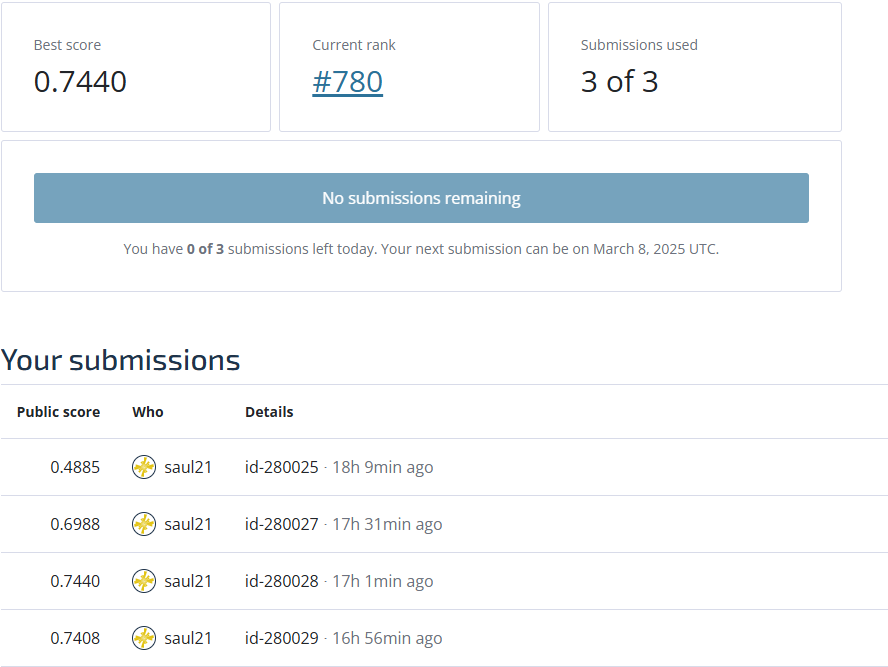